# Laplace equation

$$
\nabla^2 u = 0
$$


In [381]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random

In [ ]:
def set_seed(seed=42):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # Numpy random module
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # All GPUs (if multiple)

# Set the seed
set_seed(123)

# Define the neural network for the Physics-Informed Neural Network (PINN)
class pinn(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3):
        super(pinn, self).__init__()
        layers = [nn.Linear(2, hidden_size), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

def laplace_residual(model, coords):
    u = model(coords)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], coords, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], coords, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    return torch.mean((u_xx + u_yy) ** 2)

#Boundary conditions:
def loss_vertical_boundary(model,type,boundary_points,boundary_target):
    if type=="dirichlet":
        u_pred = model(boundary_points)
        boundary_residual= u_pred-boundary_target
        return torch.mean((boundary_residual)**2)
    elif type=="neumann":
        u_pred = model(boundary_points)
        u_grad= torch.autograd.grad(u_pred,boundary_points,grad_outputs=torch.ones_like(u_pred),create_graph=True)[0] #This is the gradient of u 
        u_x = u_grad[:,0] # This is the x-component of the gradient of u
        return torch.mean((u_x)**2)
    else:
        raise ValueError("Invalid boundary condition type")



#___________________________________BOUNDARY CONDITONS____________________________________________________
boundary_points_dirichlet = []
boundary_target_dirichlet = []

boundary_points_neumann = []
boundary_target_neumann = []

#Vertical boundary condition A, vertical_a (v_a) paramteres:
v_a_x=0   #x-coordinate of the vertical boundary
v_a_num_points=100  #Number of points on the vertical boundary
v_a_head=1  #Dirichtlet value of the boundary condition
v_a_y_start=0   #Starting y-coordinate of the vertical boundary
v_a_y_end=1     #Ending y-coordinate of the vertical boundary

#Generating tensors for the vertical boundary condition A
v_a_x_points=torch.full((v_a_num_points,1),v_a_x)
# v_a_y_points = torch.linspace(v_a_y_start, v_a_y_end, v_a_num_points).reshape(-1,1) #Should maybe change this to rand()?
v_a_y_points = v_a_y_start + (v_a_y_end - v_a_y_start) * torch.rand(v_a_num_points, 1)
boundary_points_dirichlet.append(torch.cat([v_a_x_points,v_a_y_points],dim=1))
boundary_target_dirichlet.append(torch.full((v_a_num_points,1),v_a_head,dtype=torch.float))  #This may have to be in a list?

#Vertical boundary condition B, vertical_b (v_b) paramteres:
v_b_x=0.5   #x-coordinate of the vertical boundary
v_b_num_points=100  #Number of points on the vertical boundary
v_b_head=0  #Dirichtlet value of the boundary condition
v_b_y_start=0   #Starting y-coordinate of the vertical boundary
v_b_y_end=1   #Ending y-coordinate of the vertical boundary

#Generating tensors for the vertical boundary condition B
v_b_x_points=torch.full((v_b_num_points,1),v_b_x)
# v_b_y_points = torch.linspace(v_b_y_start, v_b_y_end, v_b_num_points).reshape(-1,1) #Should maybe change this to rand()?
v_b_y_points = v_b_y_start + (v_b_y_end - v_b_y_start) * torch.rand(v_b_num_points, 1)
boundary_points_dirichlet.append(torch.cat([v_b_x_points,v_b_y_points],dim=1))
boundary_target_dirichlet.append(torch.full((v_b_num_points,1),v_b_head,dtype=torch.float))  #This may have to be in a list?

# # # #Vertical boundary condition C, vertical_c (v_c) paramteres:
# # # v_c_x=1   #x-coordinate of the vertical boundary
# # # v_c_num_points=100  #Number of points on the vertical boundary
# # # v_c_head=1  #Dirichtlet value of the boundary condition
# # # v_c_y_start=0   #Starting y-coordinate of the vertical boundary
# # # v_c_y_end=1   #Ending y-coordinate of

# # # #Generating tensors for the vertical boundary condition C
# # # v_c_x_points=torch.full((v_c_num_points,1),v_c_x)
# # # # v_c_y_points = torch.linspace(v_c_y_start, v_c_y_end, v_c_num_points).reshape(-1,1) #Should maybe change this to rand()?
# # # v_c_y_points = v_c_y_start + (v_c_y_end - v_c_y_start) * torch.rand(v_c_num_points, 1)
# # # boundary_points_dirichlet.append(torch.cat([v_c_x_points,v_c_y_points],dim=1))
# # # boundary_target_dirichlet.append(torch.full((v_c_num_points,1),v_c_head,dtype=torch.float))  #This may have to be in a list?

#Horizontal boundary condition A, horizontal_a (h_a) paramteres:




boundary_points_dirichlet = torch.cat(boundary_points_dirichlet, dim=0).requires_grad_(True)
boundary_target_dirichlet = torch.cat(boundary_target_dirichlet, dim=0)



num_domain_points=1000

# Creating domain points
x = torch.rand((num_domain_points,1),requires_grad=True) #Need to be changed to the actual domain
y = torch.rand((num_domain_points,1),requires_grad=True) #Need to be changed to the actual domain
train_points=torch.cat([x,y],dim=1) 

#Defining changeable parameters:
model=pinn(hidden_size=20, hidden_layers=3) # to be used for evaluating u at boundaries and inside the domain
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Using the Adam optimizer


epochs=5001
#Training loop:
for epoch in range(epochs):
    optimizer.zero_grad() #Have to zero the gradients at the start of each epoch
    
    #losses
    loss_laplace=laplace_residual(model,train_points)
    boundary_loss = loss_vertical_boundary(model,"dirichlet", boundary_points_dirichlet, boundary_target_dirichlet)
    loss=loss_laplace+boundary_loss

    loss.backward()
    optimizer.step()

    # Logging
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item()}, Domain Loss: {loss_laplace.item()}, Boundary Loss: {boundary_loss.item()}")

Epoch 0, Total Loss: 0.9817590117454529, Domain Loss: 0.0026075744535773993, Boundary Loss: 0.9791514277458191
Epoch 500, Total Loss: 0.20705506205558777, Domain Loss: 0.00223287520930171, Boundary Loss: 0.20482218265533447
Epoch 1000, Total Loss: 0.06126687303185463, Domain Loss: 0.0012658947380259633, Boundary Loss: 0.06000097841024399
Epoch 1500, Total Loss: 0.055182550102472305, Domain Loss: 0.0006721661775372922, Boundary Loss: 0.05451038479804993
Epoch 2000, Total Loss: 0.05179018899798393, Domain Loss: 0.0010840973118320107, Boundary Loss: 0.05070609226822853
Epoch 2500, Total Loss: 0.046021055430173874, Domain Loss: 0.001149292103946209, Boundary Loss: 0.04487176239490509
Epoch 3000, Total Loss: 0.041139084845781326, Domain Loss: 0.0015764711424708366, Boundary Loss: 0.039562612771987915
Epoch 3500, Total Loss: 0.038229625672101974, Domain Loss: 0.0016836823197081685, Boundary Loss: 0.03654594346880913
Epoch 4000, Total Loss: 0.03580911085009575, Domain Loss: 0.0014390139840543

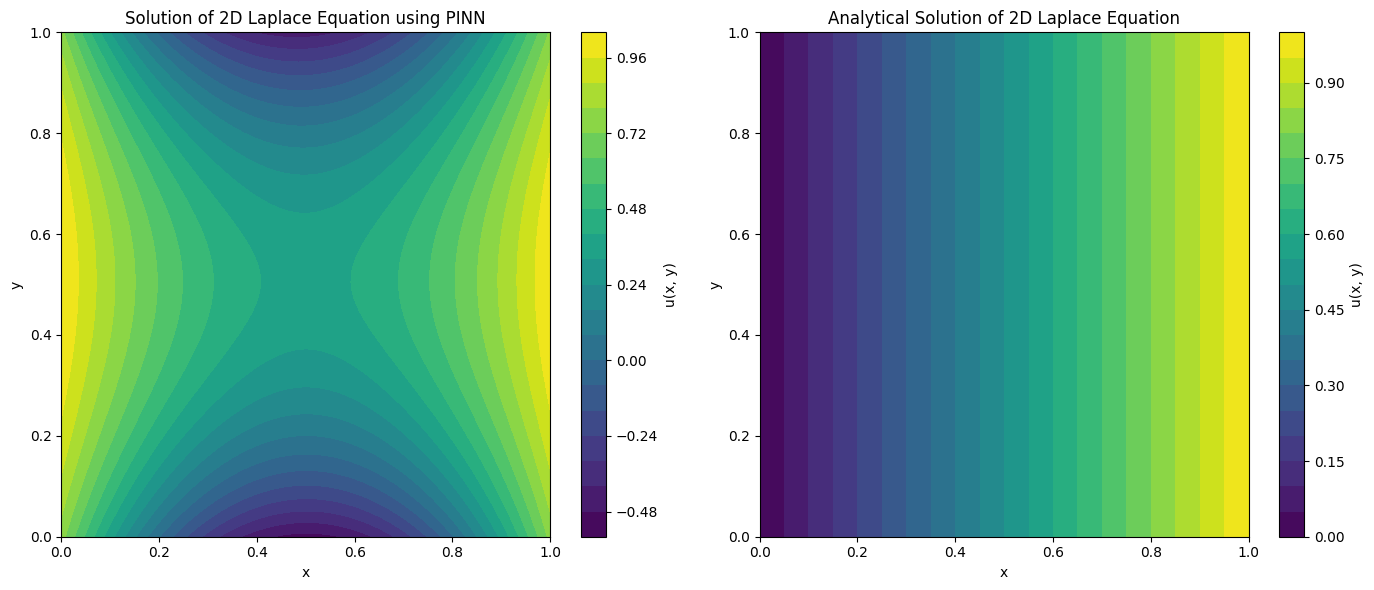

In [414]:
# Plot the results
x = y = torch.linspace(0, 1, 100)
X, Y = torch.meshgrid(x, y)
test_points = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# PINN solution
predicted_u = model(test_points).detach().numpy().reshape(100, 100) #detach, numpy are used to convert the tensor to numpy array, reshape to coordinates.

# Analytical solution
analytical_u = X.numpy()  # since u(x, y) = x

plt.figure(figsize=(14, 6))

# PINN solution plot
plt.subplot(1, 2, 1)
plt.contourf(X.numpy(), Y.numpy(), predicted_u, 20, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution of 2D Laplace Equation using PINN")

# Analytical solution plot
plt.subplot(1, 2, 2)
plt.contourf(X.numpy(), Y.numpy(), analytical_u, 20, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Analytical Solution of 2D Laplace Equation")

plt.tight_layout()
plt.show()

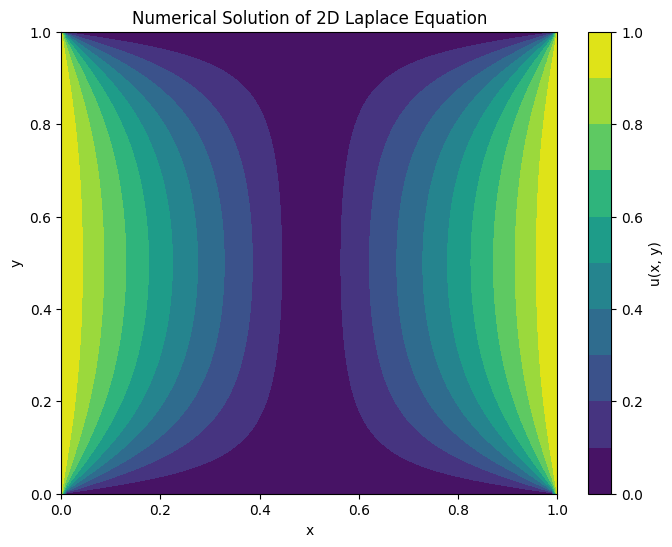

In [420]:
import numpy as np
import matplotlib.pyplot as plt

# Domain parameters
Lx, Ly = 1,1  # Domain size in x and y
Nx, Ny = 100, 100  # Number of grid points
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # Grid spacing
tolerance = 1e-7  # Convergence tolerance

# Boundary conditions
def f(y): return 1  # u(0, y) = f(y)
def g(y): return 1  # u(1, y) = g(y)
def h(x): return 10  # u(x, 0) = h(x)
def q(x): return 10  # u(x, 1) = q(x)
def s(x): return 0  # u(x, 1) = q(x)

# Initialize the solution grid with zeros
u = np.zeros((Nx, Ny))

# Apply boundary conditions
# u[:, 0] = h(np.linspace(0, Lx, Nx))  # Bottom boundary
# u[75:, -1] = s(np.linspace(0, Lx, Nx))  # Top boundary
u[0, :] = f(np.linspace(0, Ly, Ny))  # Left boundary
u[-1, :] = g(np.linspace(0, Ly, Ny))  # Right boundary
u[50, :] = s(np.linspace(0, Ly, Ny))  # Midle boundary


# Neumann condition (no flow) on the top and bottom boundaries
# u[1:-1, 0] = u[1:-1, 1]      # Bottom boundary, ∂u/∂y = 0
# u[25:75, -1] = u[25:75, -2]    # Top boundary, ∂u/∂y = 0

# Iterative solution using the finite difference method
error = 1.0  # Initialize error
while error > tolerance:
    u_old = u.copy()
    
    # Update the interior points using the finite difference scheme
    u[1:-1, 1:-1] = 0.25 * (u_old[2:, 1:-1] + u_old[:-2, 1:-1] +
                            u_old[1:-1, 2:] + u_old[1:-1, :-2])
    
    u[0, :] = f(np.linspace(0, Ly, Ny))  # Left boundary
    u[-1, :] = g(np.linspace(0, Ly, Ny))  # Right boundary
    u[50, :] = s(np.linspace(0, Ly, Ny))  # Midle boundary
    # Neumann condition (no flow in x-direction at x = 1): ∂u/∂x = 0
    # u[74, 85:-1] = u[75, 85:-1]
    # u[1:-1,0]=u[1:-1,1]
    # u[25:75, -1] = u[25:75, -2]    # Top boundary, ∂u/∂y = 0

    # Compute the error as the maximum difference between old and new values
    error = np.max(np.abs(u - u_old))

# Plot the results
X, Y = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny))
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u.T, 10, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Numerical Solution of 2D Laplace Equation")
plt.show()

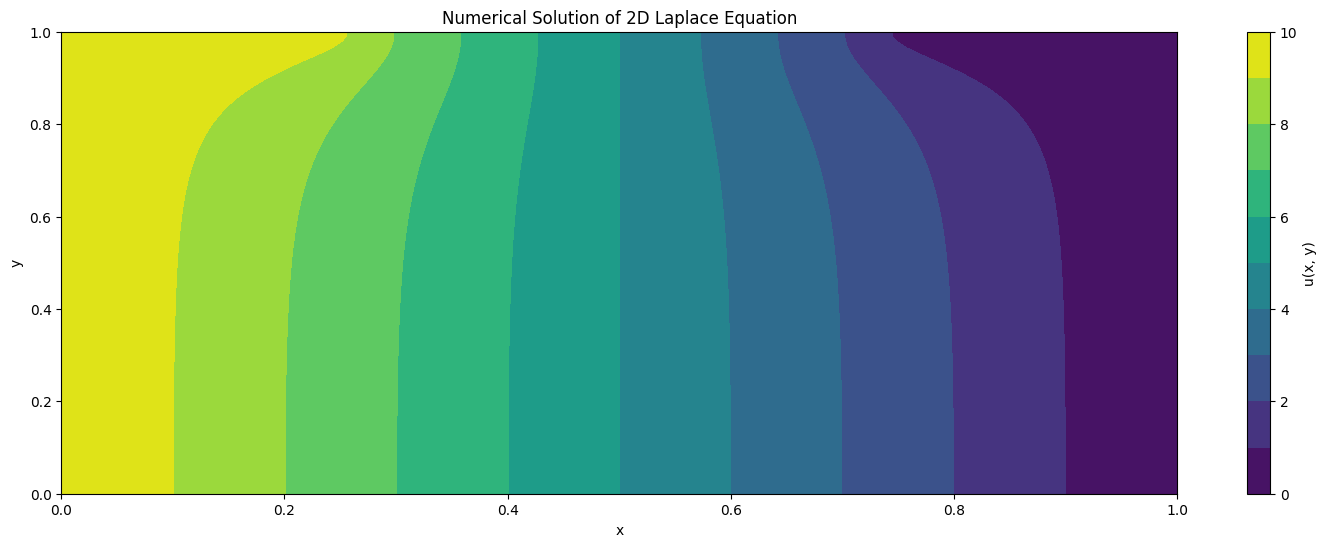

In [221]:
import numpy as np
import matplotlib.pyplot as plt

# Domain parameters
Lx, Ly = 1,1  # Domain size in x and y
Nx, Ny = 100, 100  # Number of grid points
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # Grid spacing
tolerance = 1e-7  # Convergence tolerance

# Boundary conditions
def f(y): return 10  # u(0, y) = f(y)
def g(y): return 0  # u(1, y) = g(y)
def h(x): return 10  # u(x, 0) = h(x)
def q(x): return 10  # u(x, 1) = q(x)
def s(x): return 0  # u(x, 1) = q(x)

# Initialize the solution grid with zeros
u = np.zeros((Nx, Ny))

# Apply boundary conditions
u[:, 0] = h(np.linspace(0, Lx, Nx))  # Bottom boundary
u[1:25, -1] = q(np.linspace(0, Lx, Nx))  # Top boundary
u[75:, -1] = s(np.linspace(0, Lx, Nx))  # Top boundary
u[0, :] = f(np.linspace(0, Ly, Ny))  # Left boundary
u[-1, :] = g(np.linspace(0, Ly, Ny))  # Right boundary


# Neumann condition (no flow) on the top and bottom boundaries
u[1:-1, 0] = u[1:-1, 1]      # Bottom boundary, ∂u/∂y = 0
u[25:75, -1] = u[25:75, -2]    # Top boundary, ∂u/∂y = 0

# Iterative solution using the finite difference method
error = 1.0  # Initialize error
while error > tolerance:
    u_old = u.copy()
    
    # Update the interior points using the finite difference scheme
    u[1:-1, 1:-1] = 0.25 * (u_old[2:, 1:-1] + u_old[:-2, 1:-1] +
                            u_old[1:-1, 2:] + u_old[1:-1, :-2])
    
    # Neumann condition (no flow in x-direction at x = 1): ∂u/∂x = 0
    # u[74, 85:-1] = u[75, 85:-1]
    u[1:-1,0]=u[1:-1,1]
    u[25:75, -1] = u[25:75, -2]    # Top boundary, ∂u/∂y = 0

    # Compute the error as the maximum difference between old and new values
    error = np.max(np.abs(u - u_old))

# Plot the results
X, Y = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny))
plt.figure(figsize=(18, 6))
plt.contourf(X, Y, u.T, 10, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Numerical Solution of 2D Laplace Equation")
plt.show()

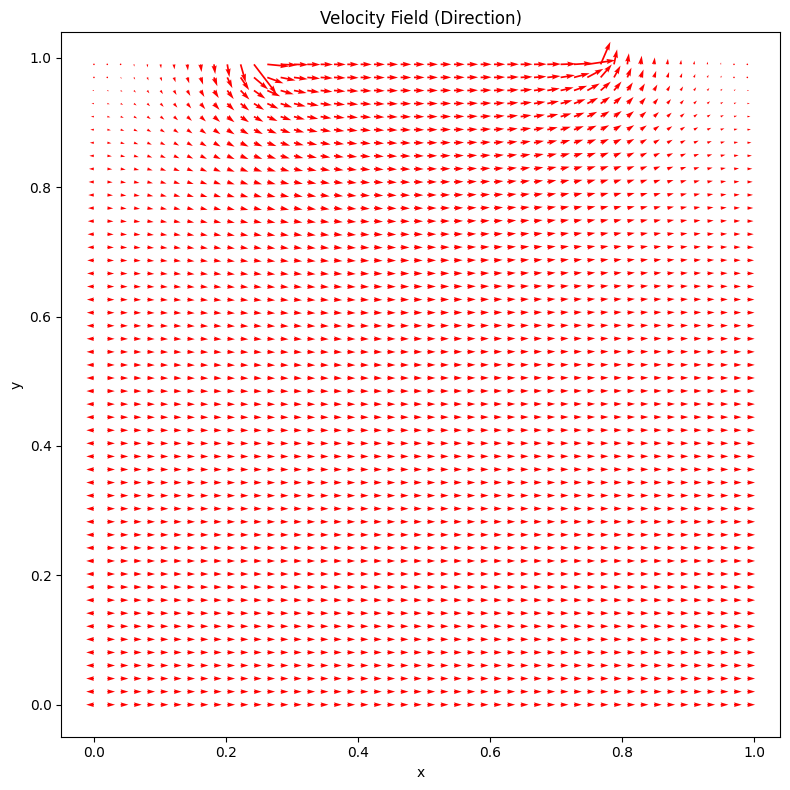

In [222]:
# Define the downsampling rate for the arrows
pil_x = pil_y = 40  # Number of arrows in x and y directions
K=1

# Compute velocity field (v_x and v_y) from the gradient of u
v_x = np.zeros_like(u)
v_y = np.zeros_like(u)

# Central differences for interior points
v_x[1:-1, :] = (u[2:, :] - u[:-2, :]) / (2 * dx)
v_y[:, 1:-1] = (u[:, 2:] - u[:, :-2]) / (2 * dy)

# Forward/backward differences for boundaries
v_x[0, :] = -K*(u[1, :] - u[0, :]) / dx  # Left boundary
v_x[-1, :] = -K*(u[-1, :] - u[-2, :]) / dx  # Right boundary
v_y[:, 0] = -K*(u[:, 1] - u[:, 0]) / dy  # Bottom boundary
v_y[:, -1] = -K*(u[:, -1] - u[:, -2]) / dy  # Top boundary

# Full grid for plotting the potential field
X, Y = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny))

# Downsample for arrow plotting
step_x = Nx // pil_x
step_y = Ny // pil_y
X_downsampled = X[::step_x, ::step_y]
Y_downsampled = Y[::step_x, ::step_y]
v_x_downsampled = v_x[::step_x, ::step_y]
v_y_downsampled = v_y[::step_x, ::step_y]

# Plot the potential field
plt.figure(figsize=(8, 8))

# Plot the velocity field (direction and magnitude) on downsampled grid
plt.quiver(X_downsampled, Y_downsampled, -v_x_downsampled.T, -v_y_downsampled.T, color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Velocity Field (Direction)")

plt.tight_layout()
plt.show()

In [102]:
print(v_x[-1,10])

1.7615890428944188


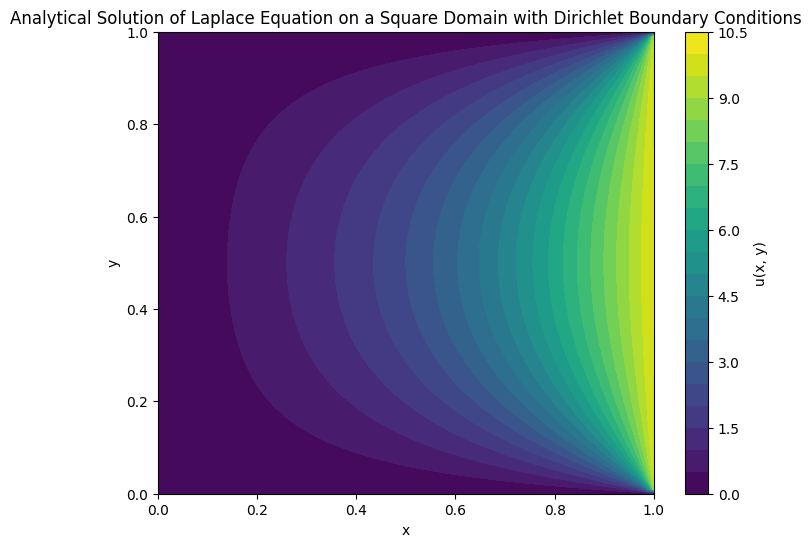

In [225]:
def analytical_solution_dirichlet_square(x, y, U=1.0, L=1.0, num_terms=100):
    """
    Computes the analytical solution of the Laplace equation on a square domain
    with Dirichlet boundary conditions on all sides: fixed potential on the top boundary, zero elsewhere.

    Parameters:
        x (np.ndarray): x-coordinates (2D array)
        y (np.ndarray): y-coordinates (2D array)
        U (float): Potential difference (default is 1.0 for top boundary)
        L (float): Side length of the square (default is 1.0)
        num_terms (int): Number of terms in the series for approximation (default is 100)

    Returns:
        np.ndarray: Analytical solution for u(x, y) on the given grid
    """
    u = np.zeros_like(x)
    for n in range(num_terms):
        term = (1 / (2 * n + 1)) * \
               (np.sinh((2 * n + 1) * np.pi * x / L) / np.sinh((2 * n + 1) * np.pi)) * \
               np.sin((2 * n + 1) * np.pi * y / L)
        u += term
    u *= (4 * U / np.pi)
    return u

# Define grid
L = 1.0
Nx, Ny = 100, 100
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
X, Y = np.meshgrid(x, y)

# Compute solution
U = 10.0
u = analytical_solution_dirichlet_square(X, Y, U=U, L=L, num_terms=100)

# Plot the solution
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u, 20, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Analytical Solution of Laplace Equation on a Square Domain with Dirichlet Boundary Conditions")
plt.show()

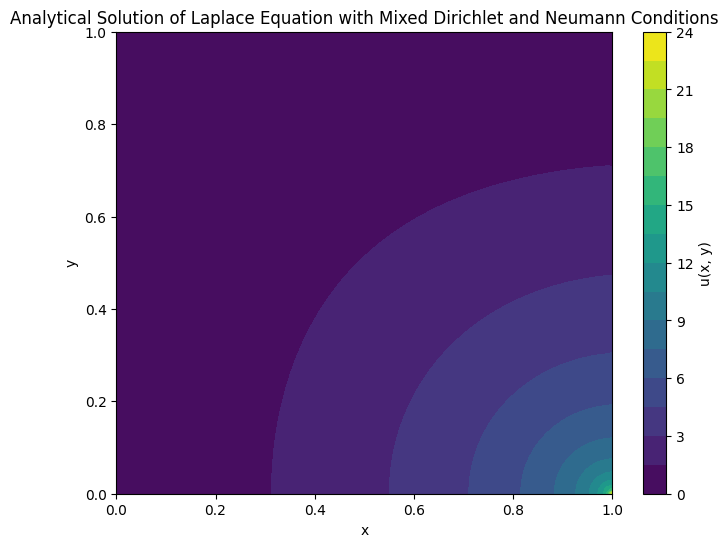

0.0
Maximum value in u is located at index: (0, 99)


In [243]:
import numpy as np
import matplotlib.pyplot as plt

def analytical_solution_mixed_boundaries(x, y, U=1.0, L=1.0, W=1.0, num_terms=50):
    """
    Computes the analytical solution of the Laplace equation on a rectangular domain
    with Dirichlet boundary conditions on the left and right, and Neumann boundary conditions on the top and bottom.

    Parameters:
        x (np.ndarray): x-coordinates (2D array)
        y (np.ndarray): y-coordinates (2D array)
        U (float): Potential on the right boundary (default is 1.0)
        L (float): Width of the rectangle in the x direction
        W (float): Height of the rectangle in the y direction
        num_terms (int): Number of terms in the series for approximation (default is 50)

    Returns:
        np.ndarray: Analytical solution for u(x, y) on the given grid
    """
    u = np.zeros_like(x)
    for n in range(num_terms):
        A_n = (4 * U) / (np.pi * (2 * n + 1))
        term = A_n * np.cos((2 * n + 1) * np.pi * y / (2 * W)) * \
               (np.sinh((2 * n + 1) * np.pi * x / (2 * W)) / np.sinh((2 * n + 1) * np.pi * L / (2 * W)))
        u += term
    return u

# Set up the domain
L, W = 1.0, 1.0  # Domain dimensions
Nx, Ny = 100, 100  # Number of points in x and y directions
x = np.linspace(0, L, Nx)
y = np.linspace(0, W, Ny)
X, Y = np.meshgrid(x, y)

# Compute the solution
U = 5.0
u = analytical_solution_mixed_boundaries(X, Y, U=U, L=L, W=W, num_terms=200)

# Plot the solution
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u, 20, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Analytical Solution of Laplace Equation with Mixed Dirichlet and Neumann Conditions")
plt.show()
print((u[1,0]))
max_index = np.unravel_index(np.argmax(u, axis=None), u.shape)
print(f"Maximum value in u is located at index: {max_index}")

In [ ]:
ind = find(M:):
L=L(ind,ind)
n=b(ind)
u=L/b
U=zeros(Nx,Ny)|
U(ind)=u


In [35]:
# Generate coordinates and boundary conditions
def generate_data(num_domain_points=1000, num_boundary_points=100):
    # Domain points
    x = torch.rand((num_domain_points, 1), requires_grad=True)
    y = torch.rand((num_domain_points, 1), requires_grad=True)
    domain_points = torch.cat([x, y], dim=1)

    # Boundary points
    boundary_points = []
    target_values = []
    
    # Boundary conditions for a square domain: [0, 1] x [0, 1]
    for value in [0.0, 1.0]:
        # u(x, 0) = 0, u(x, 1) = 1
        boundary_points.append(torch.cat([torch.rand((num_boundary_points, 1)), torch.full((num_boundary_points, 1), value)], dim=1))
        target_values.append(torch.full((num_boundary_points, 1), value))
        # u(0, y) = 0, u(1, y) = 1
        boundary_points.append(torch.cat([torch.full((num_boundary_points, 1), value), torch.rand((num_boundary_points, 1))], dim=1))
        target_values.append(torch.full((num_boundary_points, 1), value))
    
    boundary_points = torch.cat(boundary_points, dim=0).requires_grad_(True)
    target_values = torch.cat(target_values, dim=0)

    return domain_points, boundary_points, target_values

### Problem Setup

1. **Domain**:
   - **Depth**: 10 meters (from ground surface to bedrock).
   - **Excavation Depth**: 4 meters deep, with water pumped out to the bottom level of the pit.
   - **Width of Domain**: 2.5 meters (using symmetry for the 5-meter width of the pit).

2. **Boundary Conditions**:
   - **Ground Surface Boundary (Outside the Pit)**: Water head is set to the ground surface level (10 meters).
   - **Excavation Pit Floor**: Water head inside the excavation pit is at the bottom of the pit, so 4 meters below the surface.
   - **Sheet Pile Wall (Impermeable Boundary)**: This boundary goes down 6 meters, creating a no-flow condition along this section.
   - **Bedrock (Impermeable)**: The bedrock at 10 meters depth is also impermeable, leading to a no-flow condition.

3. **Symmetry Boundary Condition**:
   - Along the symmetry line (middle of the pit), there is no lateral flow, which results in a no-flow (Neumann) boundary condition.


### Boundary Conditions

1. **Ground Surface Boundary (Outside the Pit)**: 
   - The water head is set to the ground surface level, which is 10 meters.
   - Boundary condition: $u(x, 0) = 10$.

2. **Excavation Pit Floor**: 
   - The water head inside the excavation pit is at the bottom of the pit, 4 meters below the surface.
   - Boundary condition: $u(x, -4) = 4$.

3. **Sheet Pile Wall (Impermeable Boundary)**: 
   - The wall extends down to 6 meters, creating a no-flow condition along this section.
   - Boundary condition: $\frac{\partial u}{\partial x} = 0$ along the wall from 0 to 6 meters depth.

4. **Bedrock (Impermeable)**: 
   - The bedrock at 10 meters depth is impermeable, leading to a no-flow condition.
   - Boundary condition: $\frac{\partial u}{\partial y} = 0$ at 10 meters depth.

5. **Symmetry Boundary Condition**: 
   - Along the symmetry line (middle of the excavation pit), there is no lateral flow, resulting in a no-flow condition.
   - Boundary condition: $\frac{\partial u}{\partial x} = 0$ along the symmetry boundary.



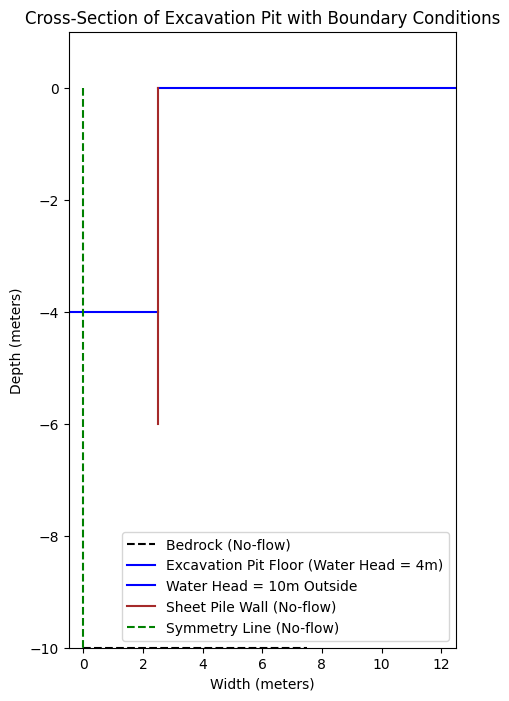

In [38]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(5, 8))

# Define coordinates for different regions and boundaries
# Excavation pit
excavation_depth = -4
pit_width_half = 2.5  # Half-width due to symmetry

# Bedrock depth
bedrock_depth = -10

# Sheet pile wall
sheet_pile_depth = -6
sheet_pile_x = pit_width_half

# Water levels
water_outside = 0  # Groundwater level outside the pit
water_inside = -4    # Groundwater level inside the pit at bottom of excavation

# Draw bedrock line
ax.plot([0, 7.5], [bedrock_depth, bedrock_depth], color='black', linestyle='--', label='Bedrock (No-flow)')

# Draw excavation pit walls and bottom
ax.plot([pit_width_half, -pit_width_half], [excavation_depth, excavation_depth], color='blue', label='Excavation Pit Floor (Water Head = 4m)')

# Draw water level outside
ax.plot([2.5, 2.5-bedrock_depth], [0, 0], color='blue', linestyle='-', label='Water Head = 10m Outside')

# Draw sheet pile wall
ax.plot([sheet_pile_x, sheet_pile_x], [0, sheet_pile_depth], color='brown', linestyle='-', label='Sheet Pile Wall (No-flow)')

# Draw symmetry line (no-flow boundary)
ax.plot([0, 0], [0, bedrock_depth], color='green', linestyle='--', label='Symmetry Line (No-flow)')

# Labels
ax.set_title("Cross-Section of Excavation Pit with Boundary Conditions")
ax.set_xlabel("Width (meters)")
ax.set_ylabel("Depth (meters)")
ax.set_xlim(-.5, 2.5-bedrock_depth)
ax.set_ylim(bedrock_depth, 1)

# Add legend
ax.legend(loc='lower right')

# Show the plot
plt.show()


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define your PINN model (based on the class we set up earlier)
class PINN(nn.Module):
    def __init__(self, N_INPUT, N_HIDDEN, N_OUTPUT, N_LAYERS):
        super(PINN, self).__init__()
        self.input_layer = nn.Linear(N_INPUT, N_HIDDEN)
        self.hidden_layers = nn.ModuleList([nn.Linear(N_HIDDEN, N_HIDDEN) for _ in range(N_LAYERS - 1)])
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        return x

# Instantiate the model, optimizer, and set up training points
model = PINN(N_INPUT=2, N_HIDDEN=32, N_OUTPUT=1, N_LAYERS=4)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define points for different regions in the domain
n_points = 100  # Number of points in each boundary region and interior

# Interior points for PDE residual
x_interior = torch.rand((n_points, 1)) * 7.5  # Random x in [0, 7.5]
y_interior = torch.rand((n_points, 1)) * 10   # Random y in [0, 10]
x_interior.requires_grad_(True)
y_interior.requires_grad_(True)

# Boundary points for Dirichlet and Neumann conditions
x_surface = torch.rand((n_points, 1)) * 7.5
y_surface = torch.zeros((n_points, 1), requires_grad=True)

x_bedrock = torch.rand((n_points, 1)) * 7.5
y_bedrock = torch.full((n_points, 1), 10.0, requires_grad=True)  # Fix: requires_grad=True

x_symmetry = torch.zeros((n_points, 1), requires_grad=True)
y_symmetry = torch.rand((n_points, 1)) * 10

x_sheet_pile = torch.full((n_points, 1), 2.5, requires_grad=True)  # Fix: requires_grad=True
y_sheet_pile = torch.rand((n_points, 1)) * 6

x_excavation = torch.rand((n_points, 1)) * 2.5
y_excavation = torch.full((n_points, 1), 4.0, requires_grad=True)  # Fix: requires_grad=True


# Function to compute the Laplace residual for the interior points
def laplace_residual(u, x, y):
    du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    du_dy = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]
    d2u_dy2 = torch.autograd.grad(du_dy, y, grad_outputs=torch.ones_like(du_dy), create_graph=True)[0]
    return d2u_dx2 + d2u_dy2

# Training loop
n_epochs = 10000
for epoch in range(n_epochs):
    optimizer.zero_grad()

    # Compute Laplace residual for the interior points
    u_interior = model(torch.cat([x_interior, y_interior], dim=1))
    laplace_res = laplace_residual(u_interior, x_interior, y_interior)
    loss_pde = torch.mean(laplace_res ** 2)

    # Boundary condition losses
    # Dirichlet boundary at the surface
    u_surface = model(torch.cat([x_surface, y_surface], dim=1))
    loss_surface = torch.mean((u_surface - 10) ** 2)  # Water head = 10 at surface

    # Dirichlet boundary at the pit floor
    u_excavation = model(torch.cat([x_excavation, y_excavation], dim=1))
    loss_excavation = torch.mean((u_excavation - 4) ** 2)  # Water head = 4 at pit floor

    # Neumann boundary at the bedrock
    u_bedrock = model(torch.cat([x_bedrock, y_bedrock], dim=1))
    du_dy_bedrock = torch.autograd.grad(u_bedrock, y_bedrock, grad_outputs=torch.ones_like(u_bedrock), create_graph=True)[0]
    loss_bedrock = torch.mean(du_dy_bedrock ** 2)

    # Neumann boundary at the symmetry line
    u_symmetry = model(torch.cat([x_symmetry, y_symmetry], dim=1))
    du_dx_symmetry = torch.autograd.grad(u_symmetry, x_symmetry, grad_outputs=torch.ones_like(u_symmetry), create_graph=True)[0]
    loss_symmetry = torch.mean(du_dx_symmetry ** 2)

    # Neumann boundary at the sheet pile wall
    u_sheet_pile = model(torch.cat([x_sheet_pile, y_sheet_pile], dim=1))
    du_dx_sheet_pile = torch.autograd.grad(u_sheet_pile, x_sheet_pile, grad_outputs=torch.ones_like(u_sheet_pile), create_graph=True)[0]
    loss_sheet_pile = torch.mean(du_dx_sheet_pile ** 2)

    # Total loss
    loss = loss_pde + loss_surface + loss_excavation + loss_bedrock + loss_symmetry + loss_sheet_pile
    loss.backward()
    optimizer.step()

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 115.05623626708984
Epoch 1000, Loss: 0.04086632281541824
Epoch 2000, Loss: 0.015139848925173283
Epoch 3000, Loss: 0.016917189583182335
Epoch 4000, Loss: 0.009105946868658066
Epoch 5000, Loss: 0.007670450024306774
Epoch 6000, Loss: 0.0068151443265378475
Epoch 7000, Loss: 0.006105321925133467


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Define grid of test points across the domain
x_test = torch.linspace(0, 7.5, 100).view(-1, 1)  # x from 0 to 7.5 meters
y_test = torch.linspace(0, 10, 100).view(-1, 1)   # y from 0 to 10 meters

# Create mesh grid for plotting
X, Y = torch.meshgrid(x_test.squeeze(), y_test.squeeze(), indexing='ij')
grid_points = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# Make predictions using the trained model
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    u_pred = model(grid_points).cpu().numpy()  # Get predictions and move to numpy for plotting

# Reshape predictions to match grid shape
U = u_pred.reshape(100, 100)

# Plot the results
plt.figure(figsize=(10, 8))
plt.contourf(X.numpy(), Y.numpy(), U, levels=50, cmap='viridis')
plt.colorbar(label='Water Head (m)')
plt.title('Predicted Water Head Distribution')
plt.xlabel('Width (m)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()  # Invert y-axis to have depth increase downward
plt.show()


# PINN for solving heat equation

1D heat equation in soil:


In [ ]:
# Defining PINN model
class PINN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation(),])
        self.fch=nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN),activation()]) 
                                 for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [ ]:
# Defining boundary conditions

In [ ]:
# Training the model using the PINN model